369.97351494506137
4400.0


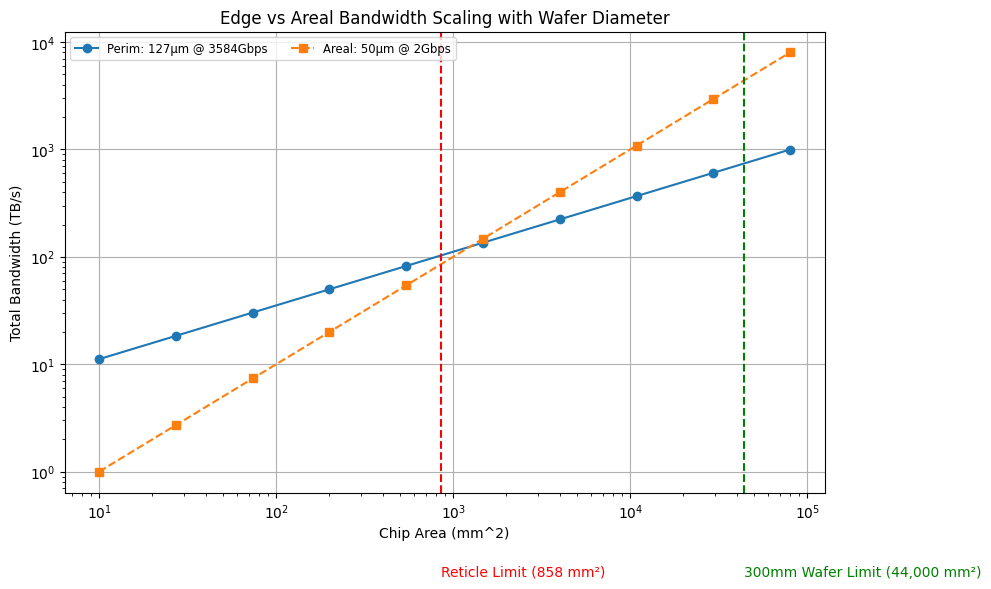

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# --- Wafer diameters (mm) ---
wafer_diameters_mm = np.linspace(50, 300, 9)  # from 50 mm to 450 mm
# --- Chip areas (mm^2) ---
chip_areas_mm2 = np.geomspace(10, 80000, 10)
# --- Edge (perimeter) I/O parameters ---
edge_io_pitches_um = [127]               # micrometers
edge_io_data_rates_gbps = [32*112]           # Gbps per edge I/O

# --- Areal I/O parameters ---
areal_io_pitches_um = [50]               # micrometers
areal_io_data_rates_gbps = [2]         # Gbps per areal I/O

def calc_perimeter_bandwidth(area_mm2, pitch_um, data_rate_gbps):
    diameter_mm = np.sqrt(4 * area_mm2 / np.pi)
    perimeter_mm = np.sqrt(area_mm2) # assume square chip

    num_ios = perimeter_mm * 1e3 / pitch_um  # mm to µm
    return (num_ios * data_rate_gbps) / 8e3  # TB/s

def calc_areal_bandwidth(area_mm2, pitch_um, data_rate_gbps):
    num_ios = area_mm2 * 1e6 / (pitch_um ** 2)  # mm² to µm²
    return (num_ios * data_rate_gbps) / 8e3  # TB/s

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))

# Perimeter bandwidth curves
for pitch_um, data_rate in itertools.product(edge_io_pitches_um, edge_io_data_rates_gbps):
    perim_bw = [calc_perimeter_bandwidth(a, pitch_um, data_rate) for a in chip_areas_mm2]
    label = f"Perim: {pitch_um}µm @ {data_rate}Gbps"
    ax.plot(chip_areas_mm2, perim_bw, linestyle='-', marker='o', label=label)
print(calc_perimeter_bandwidth(44000, 127, 16*112))

# Areal bandwidth curves
for pitch_um, data_rate in itertools.product(areal_io_pitches_um, areal_io_data_rates_gbps):
    areal_bw = [calc_areal_bandwidth(a, pitch_um, data_rate) for a in chip_areas_mm2]
    label = f"Areal: {pitch_um}µm @ {data_rate}Gbps"
    ax.plot(chip_areas_mm2, areal_bw, linestyle='--', marker='s', label=label)
print(calc_areal_bandwidth(44000, 50, 2))
# --- Formatting ---
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Chip Area (mm^2)")
ax.set_ylabel("Total Bandwidth (TB/s)")
ax.set_title("Edge vs Areal Bandwidth Scaling with Wafer Diameter")
ax.grid(True)
ax.legend(ncol=2, fontsize='small')

plt.axvline(x=858, color='r', linestyle='--', label='Reticle Limit (858 mm²)')
plt.text(x=858, y=0.1, s='Reticle Limit (858 mm²)', color='r', fontsize=10, verticalalignment='bottom')
plt.axvline(x=44000, color='g', linestyle='--', label='Wafer Limit (44,000 mm²)')
plt.text(x=44000, y=0.1, s='300mm Wafer Limit (44,000 mm²)', color='g', fontsize=10, verticalalignment='bottom')


plt.tight_layout()
plt.show()


In [ ]:
from qcsimsim import QuantumCircuit, PerformanceSimulator, HardwareConfig
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict

hardware = HardwareConfig(
        num_nodes=2048,
        mem_bandwidth_GBps=40,
        inter_node_bandwidth_GBps=5.5,
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=32
    )
print(int(math.log2(hardware.num_nodes * hardware.mem_per_device_GB * 1e9//16)))
qubit_counts = list(range(10, int(math.log2(hardware.num_nodes * hardware.mem_per_device_GB * 1e9//16)), 2)) 
num_trials = 100  # Number of random circuits per qubit count
times_by_gates = defaultdict(list)

for gates in range(200,1001,200):

    for nq in qubit_counts:
        trial_times = []
        for _ in range(num_trials):
            circuit = QuantumCircuit(
                num_qubits=nq,
                gates="random",
                num_gates=gates,
                sim_type="Schrödinger"
            )
            simulator = PerformanceSimulator(circuit, hardware)
            time_taken = simulator.simulate()
            trial_times.append(time_taken)  # s
        times_by_gates[gates].append(np.mean(trial_times))

# Plot: one curve per gates value
plt.figure(figsize=(10, 6))
for gates, times in times_by_gates.items():
    plt.plot(qubit_counts, times, label=f"{gates} gates")

plt.xlabel("Number of qubits")
plt.ylabel("Average execution time (s)")
plt.title("Execution time vs Qubits for different numbers of gates")
plt.legend()
plt.grid(True)
plt.show()

41


NameError: name 'circuit' is not defined

/Users/robertbao/Library/Python/3.9/lib/python/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/robertbao/Library/Python/3.9/lib/python/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


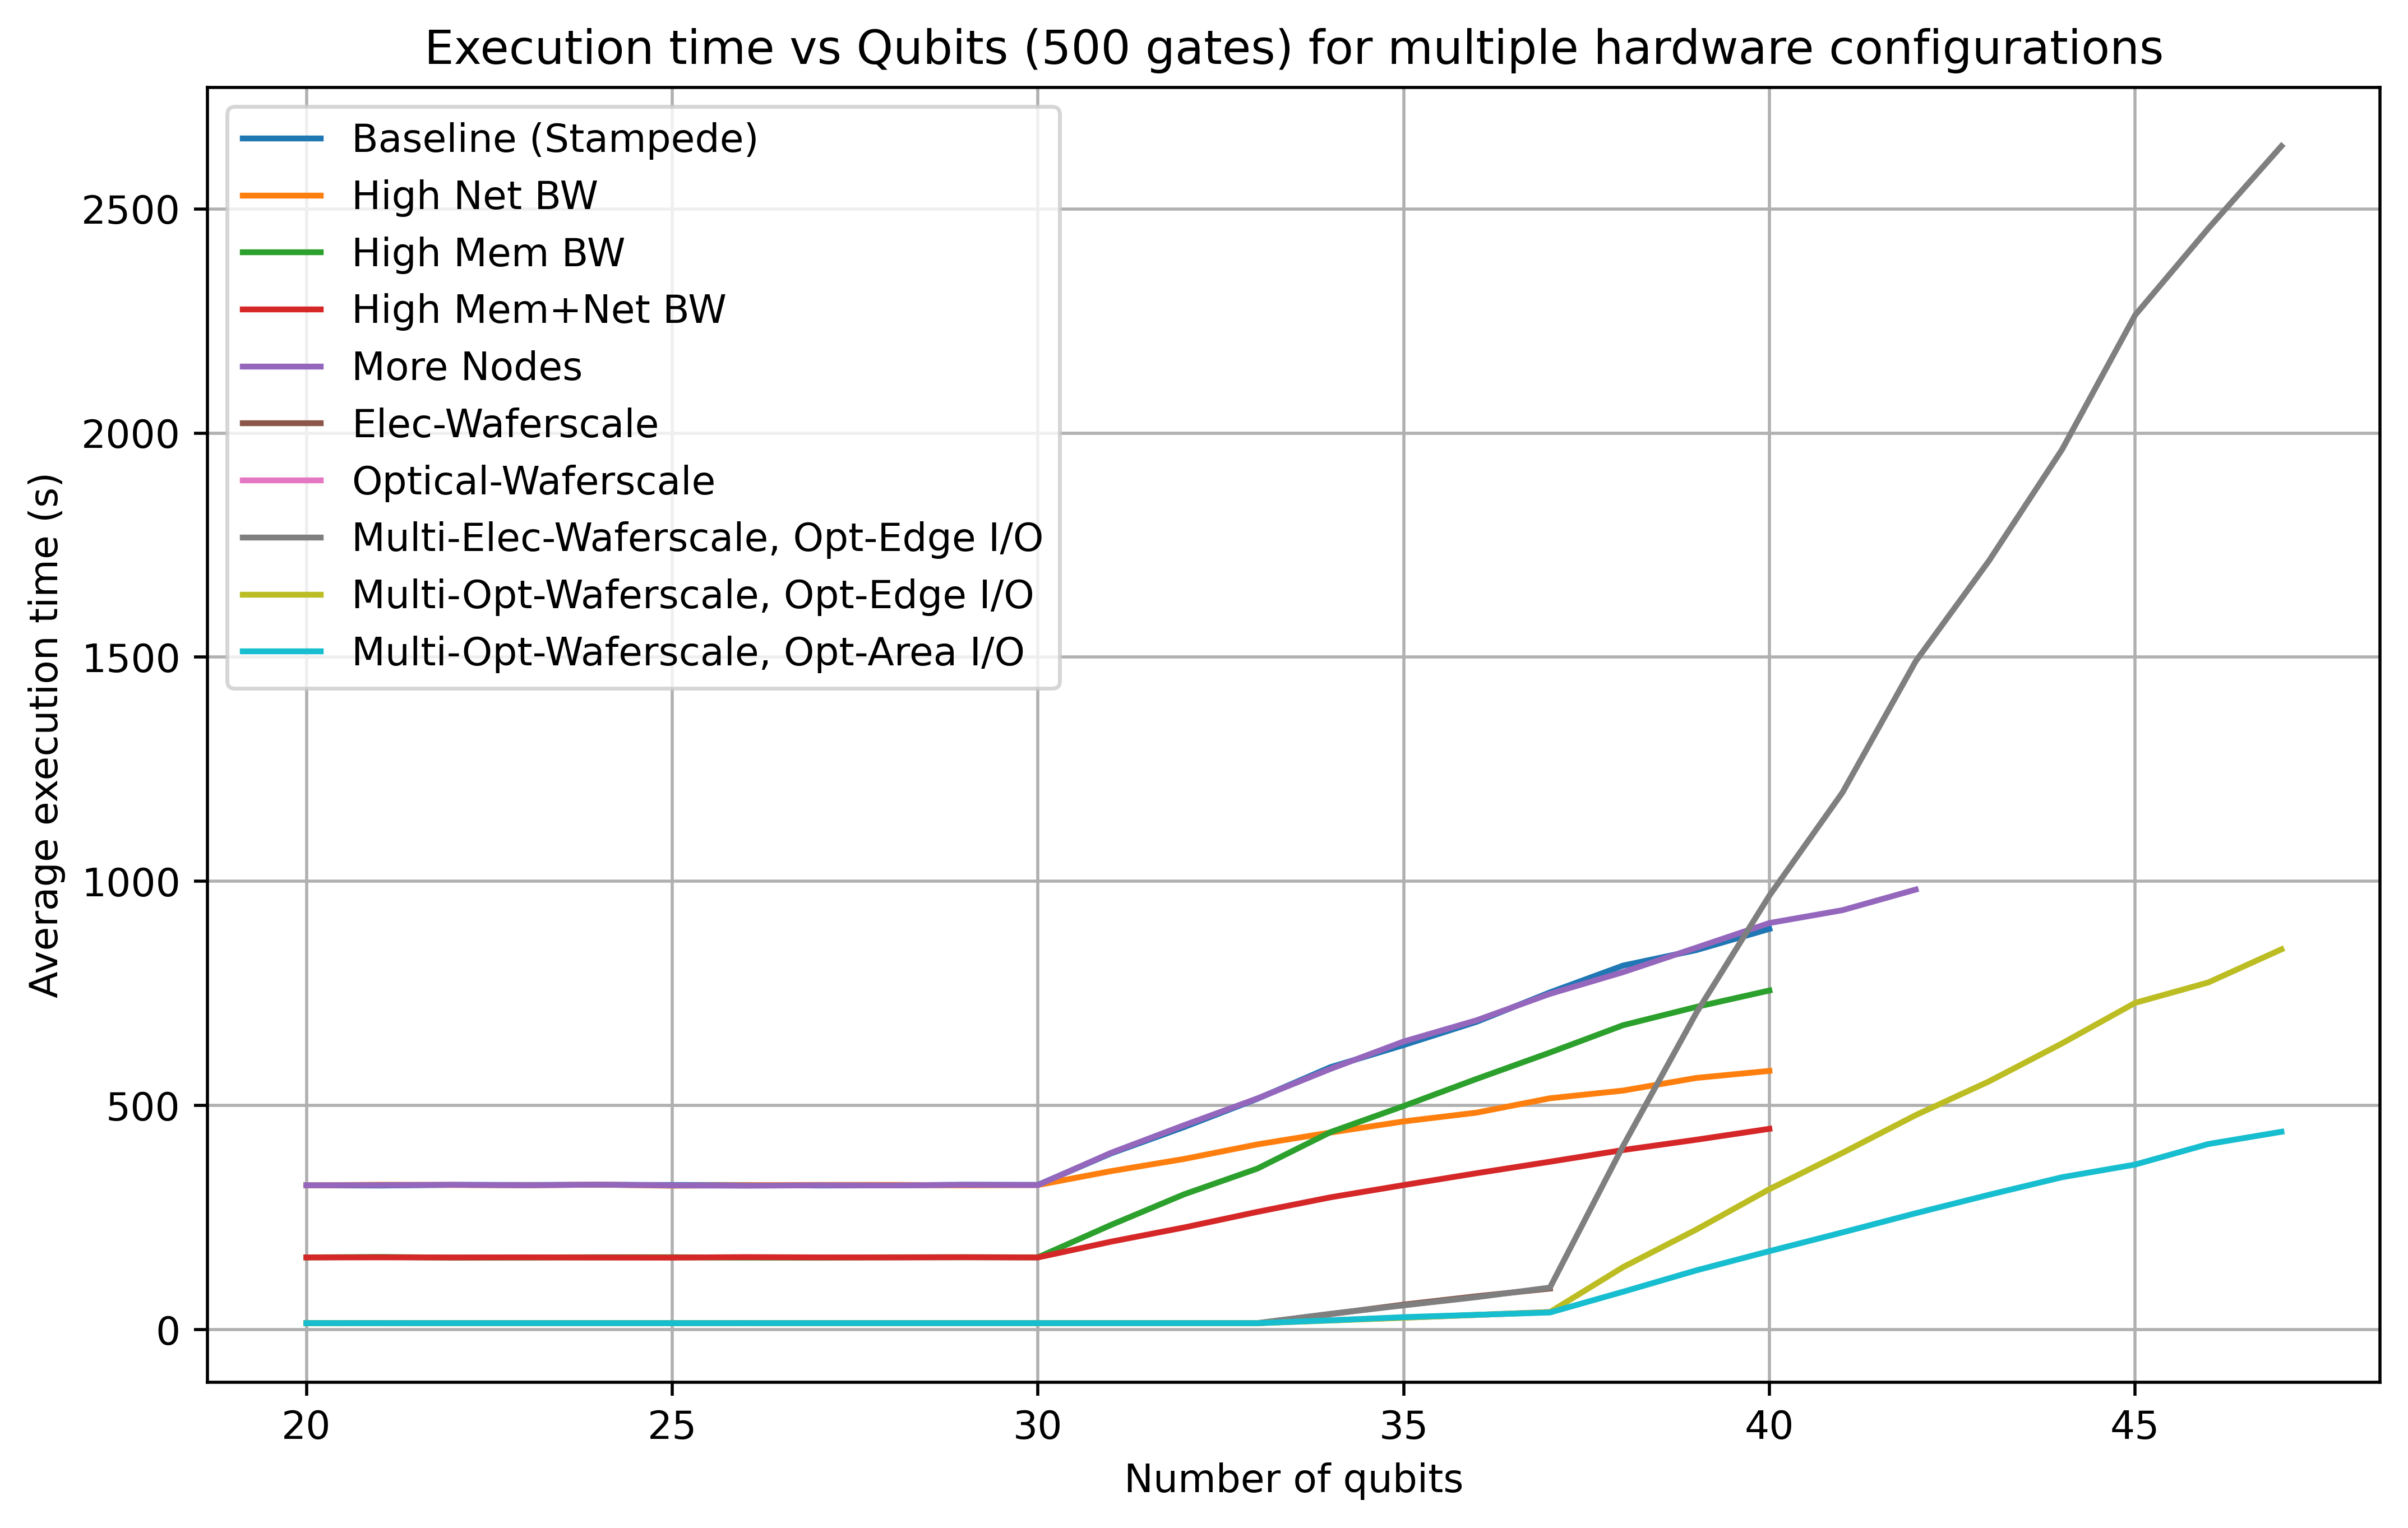

In [ ]:
from qcsimsim import QuantumCircuit, PerformanceSimulator, HardwareConfig
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import defaultdict

# Define multiple hardware configurations
hardware_configs = {
    "Baseline (Stampede)": HardwareConfig(
        num_nodes=1024,
        mem_bandwidth_GBps=40,
        inter_node_bandwidth_GBps=5.5,
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=32,
        flops_per_device=8*16*2*(2.7e9)  # 8 cores, 16 flops/core, 2 cores/node, 2.7 GHz
    ),
    "High Net BW": HardwareConfig(
        num_nodes=1024,
        mem_bandwidth_GBps=40,
        inter_node_bandwidth_GBps=11,   # Higher network bandwidth
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=32,
        flops_per_device=8*16*2*(2.7e9)  # 8 cores, 16 flops/core, 2.7 GHz

    ),
    "High Mem BW": HardwareConfig(
        num_nodes=1024,
        mem_bandwidth_GBps=80,
        inter_node_bandwidth_GBps=5.5,
        mem_latency_ns=100,           # Lower memory latency
        inter_node_latency_ns=1000,      # Lower network latency
        mem_per_device_GB=32,
        flops_per_device=8*16*2*(2.7e9)  # 8 cores, 16 flops/core, 2 cores/node, 2.7 GHz
    ),
    "High Mem+Net BW": HardwareConfig(
        num_nodes=1024,
        mem_bandwidth_GBps=80,
        inter_node_bandwidth_GBps=11,
        mem_latency_ns=100,           # Lower memory latency
        inter_node_latency_ns=1000,      # Lower network latency
        mem_per_device_GB=32,
        flops_per_device=8*16*2*(2.7e9)  # 8 cores, 16 flops/core, 2 cores/node, 2.7 GHz
    ),
    
    "More Nodes": HardwareConfig(
        num_nodes=5000,               # More nodes
        mem_bandwidth_GBps=40,
        inter_node_bandwidth_GBps=5.5,
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=32,
        flops_per_device=8*16*2*(2.7e9)  
    ),
    "Elec-Waferscale": HardwareConfig(
        num_nodes=1,               # More nodes
        num_devices_per_node=24,
        mem_bandwidth_GBps=7200,
        intra_node_bandwidth_GBps=146, # 224Gbps[ucie-s]*120mm[tile perimeter]/(8*23)[tiles]
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        intra_node_latency_ns=22,
        mem_per_device_GB=216,
        flops_per_device=67e12  # H200 FP32 FLOPs
    ),
    "Optical-Waferscale": HardwareConfig(
        num_nodes=1,               # More nodes
        num_devices_per_node=24,
        mem_bandwidth_GBps=7200,
        intra_node_bandwidth_GBps=458, # 112GBps a2a, now have 24 tiles to connect -> 112*48c2/24c2
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        intra_node_latency_ns=3,
        mem_per_device_GB=216,
        flops_per_device=67e12  
    ),
    "Multi-Elec-Waferscale, Opt-Edge I/O": HardwareConfig(
        num_nodes=1024,               # More nodes
        num_devices_per_node=24,
        mem_bandwidth_GBps=7200,
        inter_node_bandwidth_GBps=146, # constrained by intrawafer icnt
        intra_node_bandwidth_GBps=146,
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=216,
        flops_per_device=67e12  
    ),
    "Multi-Opt-Waferscale, Opt-Edge I/O": HardwareConfig(
        num_nodes=1024,               # More nodes
        num_devices_per_node=24,
        mem_bandwidth_GBps=7200,
        inter_node_bandwidth_GBps=458, # constrained by intrawafer icnt
        intra_node_bandwidth_GBps=458,
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=216,
        flops_per_device=67e12  
    ),
    "Multi-Opt-Waferscale, Opt-Area I/O": HardwareConfig(
        num_nodes=1024,               # More nodes
        num_devices_per_node=24,
        mem_bandwidth_GBps=7200,
        inter_node_bandwidth_GBps=458*2, # unconstrained by intrawafer icnt
        intra_node_bandwidth_GBps=458,
        mem_latency_ns=100,
        inter_node_latency_ns=1000,
        mem_per_device_GB=216,
        flops_per_device=67e12  
    ),
}

# Common simulation settings
num_gates = 500
num_trials = 50

# Compute max qubits possible based on largest hardware config
max_qubits_possible = int(math.log2(
    max(cfg.num_nodes * cfg.num_devices_per_node * cfg.mem_per_device_GB * 1e9 // 16 for cfg in hardware_configs.values())
))
print("Max qubits possible:", max_qubits_possible)
qubit_counts = list(range(20, max_qubits_possible))

# Store times: dict of {hardware_name: [avg_times_for_each_qubit_count]}
times_by_hardware = defaultdict(list)

for hw_name, hardware in hardware_configs.items():
    for nq in qubit_counts:
        trial_times = []
        for _ in range(num_trials):
            circuit = QuantumCircuit(
                num_qubits=nq,
                gates="random",
                num_gates=num_gates,
                sim_type="Schrödinger"
            )
            try: simulator = PerformanceSimulator(circuit, hardware)
            except Exception as e:
                # print(f"Error simulating {hw_name} with {nq} qubits: {e}")
                continue
            trial_times.append(simulator.simulate())
        times_by_hardware[hw_name].append(np.mean(trial_times))

# Plot: one curve per hardware configuration
plt.figure(figsize=(10, 6))
for hw_name, times in times_by_hardware.items():
    plt.plot(qubit_counts, times, label=hw_name)

plt.xlabel("Number of qubits")
plt.ylabel("Average execution time (s)")
plt.title(f"Execution time vs Qubits ({num_gates} gates) for multiple hardware configurations")
plt.legend()
plt.rcParams['figure.dpi'] = 500  # Sets default DPI for displayed figures
plt.rcParams['savefig.dpi'] = 500 # Sets default DPI for saved figures
plt.grid(True)
plt.show()


Max qubits possible: 48


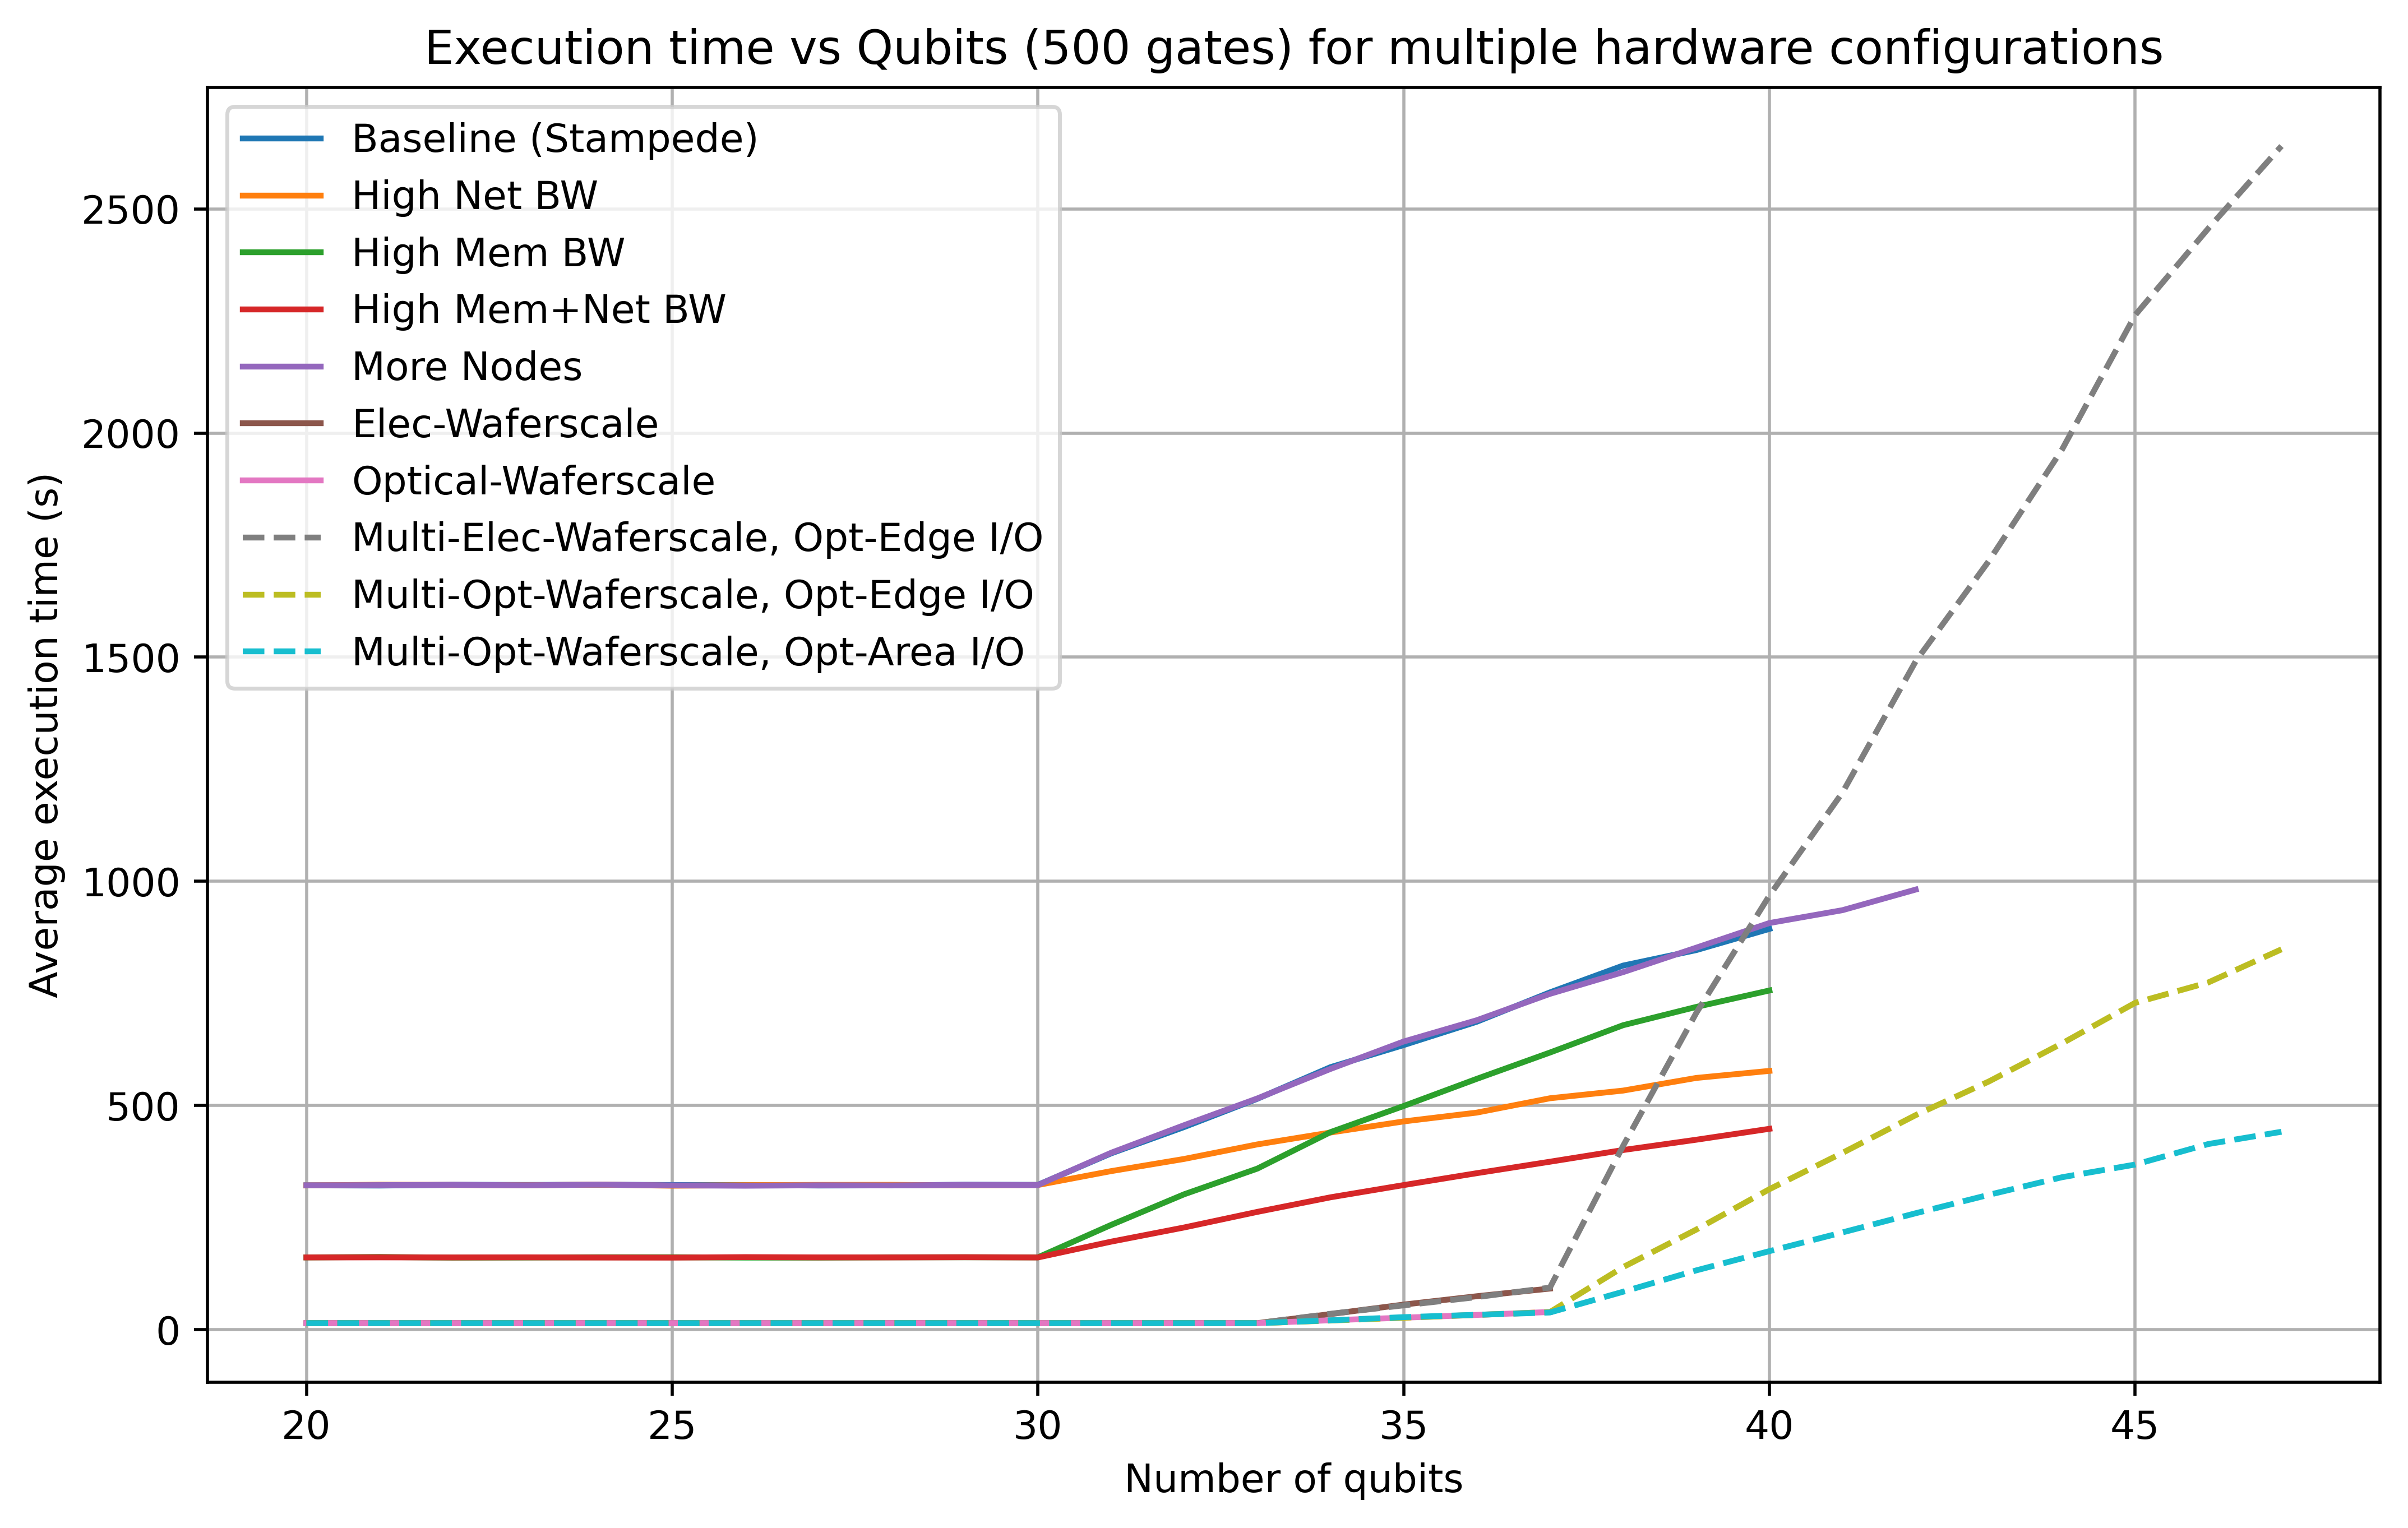

In [24]:
print("Max qubits possible:", max_qubits_possible)

# Plot: one curve per hardware configuration
plt.figure(figsize=(10, 6))
for hw_name, times in times_by_hardware.items():
    plt.plot(qubit_counts, times, label=hw_name, linestyle='dashed' if "Multi" in hw_name else 'solid')

plt.xlabel("Number of qubits")
plt.ylabel("Average execution time (s)")
plt.title(f"Execution time vs Qubits ({num_gates} gates) for multiple hardware configurations")
plt.legend()
plt.rcParams['figure.dpi'] = 500  # Sets default DPI for displayed figures
plt.rcParams['savefig.dpi'] = 500 # Sets default DPI for saved figures
plt.grid(True)
plt.show()